# FOS MNIST Example

## Outline
* [**Introduction**](#Introduction)
* [**Import Modules**](#Import-modules)
* [**Setup PyTorch**](#Setup-PyTorch)
* [**Setup FOS**](#Setup-FOS)
* [**Run the Training**](#Run-the-training)
* [**Vizualization**](#Visualization)
* [**Save and Restore**](#Save-and-restore-training-sessions)


## Introduction
This notebook demonstrates how to use **FOS** to train a MNIST model. The input for this model are scans of handwritten digits (0-9) and the target is the digit that it represents. There is only one digit per image and all images have the same shape. The dataset required to train MNIST is part of `Torchvision` and will be downloaded the first time you run this notebook.

## Import modules
Besides the Supervisor and Trainer we now also import three meters we are going to use to display metrics.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

# Import the Fos classes we are going to use in this notebook
from fos import Workout
from fos.callbacks import NotebookMeter
from fos.metrics import SingleClassAccuracy, plot_metrics

### Define Model

The first part of the script is setting up the data loaders and the model architecture. There are no specific FOS classes required here. FOS will work just fine with regular PyTorch classes like the `DataLoader` and the `nn.Module`. The model isself is a small network with 2 Convolutional layers and 2 Linear layers. Since it is so few layers and parameters, it wil run fine on most CPU's.

Also a custom metric like `accuracy` can be easily defined. It is a plain Python function of which the first argument is the predicted value (y) and the second arument is the target value (t). The output of the function is the calculated metric value itself.

In [2]:
def get_dataloaders():
    '''Loads the images required to train the model. First time will download them from the Internet.'''
    
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    
    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=128, shuffle=True)
    
    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=128, shuffle=False)
    
    return train_loader, val_loader


class DigitPredictor(nn.Module):
    '''A simple convolutional network for predicting the digits'''

    def __init__(self, n_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(1, 5, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU(),
                        nn.Conv2d(5, 10, kernel_size=5),
                        nn.MaxPool2d(2),
                        nn.ReLU())
        
        self.fc = nn.Sequential(
                        nn.Linear(160, 32),
                        nn.ReLU(),
                        nn.Linear(32, n_classes))

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

    

### Setup PyTorch

We now get to the part where we instantiate everything. The first part is the same as any other PyTorch program. The model (predictor), optimizer and loss functions are all plain PyTorch objects with no FOS magic going on. The same holds true for the two dataloaders. If you are not yet familiar with this, there are some excellent tutorials on the [PyTorch](https://pytorch.org) website.

If you have a GPU, you can change the code below that instantiates the predictor to `DigitPredictor().to("cuda")` in order to speedup the training. However since this is a small model it will also perform fine on most modern CPU's.   


In [3]:
model   = DigitPredictor()
workout = Workout(model, F.nll_loss, acc=SingleClassAccuracy())

data_train, data_valid = get_dataloaders()

## Setup FOS

The following section is where we setup the *FOS* part of the program. We start with creating some meters to capture the metrics. In this example we want to use two meters:

* `NotebookMeter` that will print the metrics in the Notebook.
* `MemoryMeter` that will just store the captured metrics in memory. 
  We will later use this to visualize the accuracy during training and validation

The `MultiMeter` is then created that includes these two meters since the trainer only accepts a single Meter object as a parameter. When the trainer forwards metrics to the MultiMeter, the MultiMeter will delegate this to these two meters. This way any arbritrary number of meters can be included in the training.

When you create a Supervisor you need to always provide the predictor (the model you want to train) and the loss function. Optionally you can pass extra metrics functions to the Supervisor initializer as a dictionary. 

The `key` is the name that will be used to publish the metric and the `value` is the actual metric function itself. For training phase the metric will be published under the name provided. And for the validation phase it will be prepended with `val_` in order to be able to distinguish the two. So in this case there will be `acc` and `val_acc` metrics displayed:

     [ 10:  5159] loss=0.04010 acc=0.98773 val_loss=0.04031 val_acc=0.98625 : 100%|██████████|00:15<00:00

In [4]:
meter = NotebookMeter(["loss", "acc", "val_loss", "val_acc"])
workout.fit(data_train, data_valid, epochs=5, callbacks=meter)

[  1:   469]  - loss : 2.27807  - acc : 0.15625  - val_loss : 2.25518  - val_acc : 0.19541 : 100%|██████████|00:09<00:00
[  2:   938]  - loss : 2.19181  - acc : 0.33333  - val_loss : 2.17774  - val_acc : 0.34155 : 100%|██████████|00:09<00:00
[  3:  1407]  - loss : 2.05981  - acc : 0.40625  - val_loss : 1.98756  - val_acc : 0.51414 : 100%|██████████|00:09<00:00
[  4:  1876]  - loss : 1.59226  - acc : 0.56250  - val_loss : 1.43357  - val_acc : 0.65993 : 100%|██████████|00:10<00:00
[  5:  2345]  - loss : 0.78041  - acc : 0.82292  - val_loss : 0.72016  - val_acc : 0.83598 : 100%|██████████|00:10<00:00

### Run the training

Remains running the trainer for a number of epochs. When we run the trainer, we supply both the data for training and validation phases and specify for how many epochs we want to run this training. If the validation data is not provided, the validation phase is skipped all together. And if no value for the numper of epochs is provided, 1 epoch is assumed.

You should see a validation accuracy of above 98% after the first 5 epochs. Since the trainer keeps track of the state, you can rerun the cell multiple times and it just continues where it left off (the epoch and step counters don't reset). This allows for a iterative development approach in for example a Jupyter notebook.

## Visualization
The workout captured the metrics and can now be used analyse the metrics. In this case we plot some graphs. We use the `plot_metrics` convenience method to do this, but by using `workout.history[metricname]` the metrics can be used for other purposes.

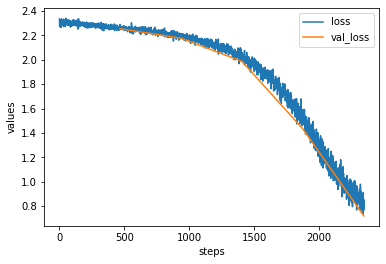

In [5]:
from matplotlib import pyplot as plt
plot_metrics(plt, workout, ["loss", "val_loss"])

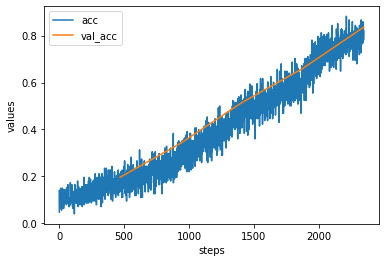

In [8]:
plot_metrics(plt, workout, ["acc", "val_acc"])

## Save and restore training sessions

If you want to save the training state, use the `workout.save()` method. You can optionally specify a filename or let a directory and filename be generated for you. The workout will save the following state:

1. Its own state, like which step and epoch it is at.
2. History of the logged metrics.
3. Model state, so the learned parameters. 
4. Optimizer state, like for example the momentum of parameters.


In [6]:
workout.save("my_best_model.pty")

'my_best_model.pty'

And if at later stage you want to continue where you left off or perhaps revert back to a previously saved version, just restore the state from one of the files with `workout.load()`.

In [7]:
workout.load("my_best_model.pty")

'my_best_model.pty'